# Analysis of Agent Based Model of Food Choice Behaviour Applied to British Milk Consumption

In [1]:
# relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import OrderedDict
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches



# Use deap to optimize  ABM output to observed data
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# nl4py allows Netlogo to be controlled from Python
import nl4py

ModuleNotFoundError: No module named 'seaborn'

## Load and process real-world milk data

In [2]:
def parser(x):
    return datetime.strptime('01-01-'+x, '%d-%m-%Y')

In [3]:
series = pd.read_csv('milktimeseriesdata.csv', header=0, index_col=0, squeeze=True)

In [4]:
milkdata = series

In [8]:
#pd.set_option('display.max_rows', None)

In [10]:
milkdata['ticks'] = np.arange(1,len(milkdata)+1,1)

In [11]:
milkdata = milkdata.reset_index()

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 8 Text major ticklabel objects>)

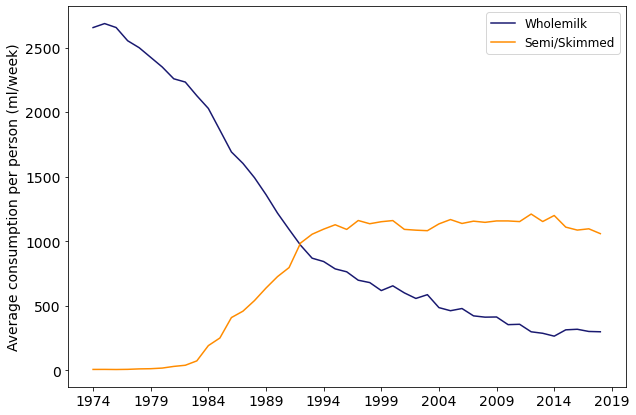

In [14]:
# Observed data - average weekly consumption of liquid whole milk and skimmed (inc. semi) milk
palette=['midnightblue','darkorange']
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(data=milkdata.iloc[:,1:-1],dashes=False,palette=palette,legend='brief',ax=ax)
#plt.legend(loc='upper right',fontsize=12)
ax.legend(['Wholemilk','Semi/Skimmed'],fontsize=12)
plt.ylabel('Average consumption per person (ml/week)',fontsize=(14))
ax.set_xticklabels(np.arange(1974, 2019+1,5),fontsize=(14))
plt.xticks(np.arange(0, 50,5))
plt.yticks(fontsize=(14))

## Model setup and calibration

In [15]:
# ABM parameters are calibrated by an evolutionary algorithm that seeks to minimise the difference with the model output and observed data at two points of the curve. 
# I.e. bi-objective optimization. The first point to minimise is the point at which whole-milk and skimmed/semi-skimmed milk consumption crosses over. 
# The second is the final level of average consumption of skimmed/semi-skimmed milk.

# Setup of the evolutionary algorithm
# setup the fitness type. Note, objective is to minimise hence weight of -1.0. 
# There are two sets of curves to minimise so a bi-objective optimisation is conducted.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))

# An individual is essentially a list of ABM paramter values for our calibration purposes. 
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

In [16]:
# start sevrer to connect to Netlogo 
nl4py.startServer('/Applications/NetLogo 6.0.4')

In [16]:
#nl4py.stopServer()

In [17]:
# create workspace to operate the model
n = nl4py.netlogoWorkspaceFactory.newNetLogoHeadlessWorkspace()

In [18]:
# open the model
n.openModel('abm_milk_choice_upload.nlogo')

In [19]:
# parameter names and ranges
parameterNames = n.getParamNames()
parameterRanges = n.getParamRanges()

In [21]:
parameterNames

['memory-lifetime',
 'alt-intrinsic-mean-initial',
 'habit-threshold',
 'p-interact',
 'social-susceptibility',
 'incumbent-initial-habit',
 'social-conformity',
 'alt-extrinsic-mean-initial',
 'social-blindness',
 'justification',
 'cognitive-dissonance-threshold',
 'network-parameter',
 'disposition-probability-gradient']

In [22]:
parameterRanges

[[1.0, 1.0, 10.0],
 [1.0, 0.01, 3.0],
 [1.0, 1.0, 10.0],
 [0.0, 0.1, 1.0],
 [0.0, 0.1, 1.0],
 [0.0, 1.0, 10.0],
 [-1.0, 0.01, 1.0],
 [0.0, 0.01, 3.0],
 [0.0, 0.01, 1.0],
 [0.0, 0.01, 1.0],
 [0.0, 0.01, 1.0],
 [2.0, 0.01, 10.0],
 [14.0, 0.1, 16.0]]

In [23]:
# create random parameter value from upper and lower bounds
parameterInitializers = []

for parameterName, parameterRange in zip(parameterNames, parameterRanges):
    parameterName = ''.join(filter(str.isalnum, str(parameterName)))
    if len(parameterRange) == 3:
        toolbox.register(parameterName, random.uniform, parameterRange[0], parameterRange[2]) #start stop, no need for step (parameterRange[1] as takes a random float)
        parameterInitializers.append(eval("toolbox."+str(parameterName)))

In [25]:
# register an individual
toolbox.register("individual", tools.initCycle, creator.Individual, tuple(parameterInitializers))

# register a population which is a set of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# hyperparameters of the calibration
lowerBounds = [row[0] for row in parameterRanges]
upperBounds = [row[2] for row in parameterRanges]
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=10, low = lowerBounds, up = upperBounds)
#toolbox.register("mutate", tools.mutUniformInt, low = lowerBounds, up = upperBounds, indpb=0.1)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=10, low = lowerBounds, up = upperBounds, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

In [27]:
# Evaluation function to minimise. Returns two RMSE metrics

def simulate(workspace_,names,values):
    workspace_.command("stop")
    for name, value in zip(names, values):
        cmd = 'set {0} {1}'.format(name, value)
        workspace_.command(cmd)
    workspace_.command('setup')
    reporters = ["ticks",'mean-incum','mean-alt']
    workspace_.scheduleReportersAndRun(reporters, 0,1,32,"go")    
    newResults = []
    while(len(newResults) == 0):
        newResults = workspace_.getScheduledReporterResults()
        if len(newResults) > 0:
            
            ###Process simulation results###
            df = pd.DataFrame(newResults)
            df.columns = ['ticks', 'mean-incum', 'mean-alt']
            df = pd.concat([df, milkdata.head(32)],axis=1)
            df['mean-incum'] = pd.to_numeric(df['mean-incum'])
            df['mean-alt'] = pd.to_numeric(df['mean-alt'])
            df['Liquid_wholemilk_ml_pppw'] = pd.to_numeric(df['Liquid_wholemilk_ml_pppw'])
            df['Skimmed_milks_ml_pppw'] = pd.to_numeric(df['Skimmed_milks_ml_pppw'])
            
            ###penalise parameter sets that do not output key points of skimmed milk curve###
            
            if df['mean-alt'].iloc[5] < 20 and (df['mean-incum'].iloc[18]-100 <= df['mean-alt'].iloc[18] <= df['mean-incum'].iloc[18]+100) : 

                rmse1 = ((df['mean-incum'] - df['Liquid_wholemilk_ml_pppw'])**2).mean() ** 0.5
                rmse2 = ((df['mean-alt'] - df['Skimmed_milks_ml_pppw'])**2).mean() ** 0.5
            
            else:
            
                rmse1 = (((df['mean-incum'] - df['Liquid_wholemilk_ml_pppw'])**2).mean() ** 0.5) + 500 
                rmse2 = (((df['mean-alt'] - df['Skimmed_milks_ml_pppw'])**2).mean() ** 0.5) + 500

    workspace_.command("stop")
    return rmse1, rmse2
    time.sleep(2)

In [28]:
# Evaluation function to minimise

def simulate_2(workspace_,names,values):
    workspace_.command("stop")
    for name, value in zip(names, values):
        cmd = 'set {0} {1}'.format(name, value)
        workspace_.command(cmd)
    workspace_.command('setup')
    reporters = ["ticks",'mean-incum','mean-alt']
    workspace_.scheduleReportersAndRun(reporters, 0,1,32,"go")    
    newResults = []
    while(len(newResults) == 0):
        newResults = workspace_.getScheduledReporterResults()
        if len(newResults) > 0:
            
            ###Process simulation results###
            df = pd.DataFrame(newResults)
            df.columns = ['ticks', 'mean-incum','mean-alt']
            df = pd.concat([df, milkdata.head(32)],axis=1)
            df['mean-incum'] = pd.to_numeric(df['mean-incum'])
            df['mean-alt'] = pd.to_numeric(df['mean-alt'])
            
            ###penalise parameter sets that do not output key points of skimmed milk curve###
            
            alpha = np.abs(20 - (df['mean-alt'].iloc[5]))
            beta = np.abs(df['mean-incum'].iloc[18] - df['mean-alt'].iloc[18])

    workspace_.command("stop")
    return alpha, beta
    time.sleep(2)

In [29]:
# Evaluation function to minimise

def simulate_3(workspace_,names,values):
    workspace_.command("stop")
    for name, value in zip(names, values):
        cmd = 'set {0} {1}'.format(name, value)
        workspace_.command(cmd)
    #workspace_.command('set model-version "sheep-wolves-grass"')
    workspace_.command('setup')
    reporters = ["ticks",'mean-incum','mean-alt']
    workspace_.scheduleReportersAndRun(reporters, 0,1,32,"go")    
    newResults = []
    while(len(newResults) == 0):
        newResults = workspace_.getScheduledReporterResults()
        if len(newResults) > 0:
            
            ###Process simulation results###
            df = pd.DataFrame(newResults)
            df.columns = ['ticks', 'mean-incum','mean-alt']
            df = pd.concat([df, milkdata.head(32)],axis=1)
            df['mean-incum'] = pd.to_numeric(df['mean-incum'])
            df['mean-alt'] = pd.to_numeric(df['mean-alt'])
            #df['Liquid_wholemilk_ml_pppw'] = pd.to_numeric(df['Liquid_wholemilk_ml_pppw'])
            #df['Skimmed_milks_ml_pppw'] = pd.to_numeric(df['Skimmed_milks_ml_pppw'])
            
            ###penalise parameter sets that do not output key points of skimmed milk curve###
            
            #alpha = np.abs(20 - (df['mean-alt'].iloc[5]))
            beta = np.abs(df['mean-incum'].iloc[18] - df['mean-alt'].iloc[18])
            gamma = np.abs(1166.87 - (df['mean-alt'].iloc[31]))

    workspace_.command("stop")
    return beta, gamma
    time.sleep(2)

In [30]:
# Evaluation function to minimise. Two metrics minimised. 1) milk type crossover 2) final level of average consumption of skimmed/semi-skimmed milk type

def simulate_4(workspace_,names,values):
    workspace_.command("stop")
    for name, value in zip(names, values):
        cmd = 'set {0} {1}'.format(name, value)
        workspace_.command(cmd)
    workspace_.command('setup')
    reporters = ["ticks",'mean-incum','mean-alt']
    workspace_.scheduleReportersAndRun(reporters, 0,1,32,"go")    
    newResults = []
    while(len(newResults) == 0):
        newResults = workspace_.getScheduledReporterResults()
        if len(newResults) > 0:
            
            ###Process simulation results###
            df = pd.DataFrame(newResults)
            df.columns = ['ticks', 'mean-incum','mean-alt']
            df = pd.concat([df, milkdata.head(32)],axis=1)
            df['mean-incum'] = pd.to_numeric(df['mean-incum'])
            df['mean-alt'] = pd.to_numeric(df['mean-alt'])
            #df['Liquid_wholemilk_ml_pppw'] = pd.to_numeric(df['Liquid_wholemilk_ml_pppw'])
            #df['Skimmed_milks_ml_pppw'] = pd.to_numeric(df['Skimmed_milks_ml_pppw'])
            
            ###penalise parameter sets that do not output key points of skimmed milk curve###
            
            #alpha = np.abs(20 - (df['mean-alt'].iloc[5]))
            #beta = np.abs(df['mean-incum'].iloc[18] - df['mean-alt'].iloc[18])
            beta2 = np.abs(984.99 - (df['mean-alt'].iloc[18]))
            gamma = np.abs(1166.87 - (df['mean-alt'].iloc[31]))

            ###Done processing simulation results###
    workspace_.command("stop")
    return beta2, gamma
    time.sleep(2)

In [33]:
#nl4py.deleteAllHeadlessWorkspaces()

In [ ]:
# creates a population - POP - of seperate workspaces for different ABM runs
nl4py.deleteAllHeadlessWorkspaces()
POP = 100
freeWorkspaces = []
for i in range(0,POP):
    n = nl4py.newNetLogoHeadlessWorkfspace()
    n.openModel('abm_milk_choice_upload.nlogo')
    freeWorkspaces.append(n)

In [35]:
# monitors free workspaces and runs the simulate function
def evaluateFoodChoice(individual):
    n = freeWorkspaces[0]
    freeWorkspaces.remove(n)
    result = simulate_3(n,parameterNames,individual)
    freeWorkspaces.append(n)
    return result

toolbox.register("evaluate", evaluateFoodChoice)

In [37]:
# parameters of the eaMuPlusLambda algorithm
MU = POP # number of individuals to select at each generation
LAMBDA = POP # number of 'children' to be created at each generation

In [38]:
# allows faster algorithm execution
import multiprocessing
from multiprocessing.pool import ThreadPool
pool = ThreadPool(multiprocessing.cpu_count())
toolbox.register("map", pool.map)

# metrics recorded
stats = tools.Statistics(key = lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("mean", np.mean)
stats.register("max", np.max)
stats.register("std", np.std)
hof = tools.ParetoFront()

final_pop, log = algorithms.eaMuPlusLambda(toolbox.population(n=POP), toolbox,  mu=MU, lambda_=LAMBDA, cxpb=0.75, mutpb=0.25, ngen=15, stats = stats, halloffame = hof)

gen	nevals	min    	mean   	max    	std    
0  	100   	16.6732	720.027	2639.94	752.655
1  	100   	3.10086	288.353	885.091	197.454
2  	100   	2.82997	244.472	885.091	212.28 
3  	100   	1.06934	205.487	885.091	206.793
4  	100   	1.06934	184.901	885.091	207.032
5  	100   	0.269168	170.776	885.091	206.413
6  	100   	0.269168	147.825	842.508	185.885
7  	100   	0.269168	137.633	842.508	179.378
8  	100   	0.269168	126.452	842.508	166.827
9  	100   	0.269168	128.942	798.372	177.744
10 	100   	0.269168	127.676	798.372	177.96 
11 	100   	0.269168	122.105	798.372	173.695
12 	100   	0.269168	120.979	798.372	173.126
13 	100   	0.269168	116.499	798.372	172.795
14 	100   	0.269168	117.432	798.372	174.397
15 	100   	0.269168	117.933	798.372	180.758


In [537]:
pd.DataFrame(toolbox.population(n=POP)).to_csv('local_filepath')

# Model outputs

In [39]:
print(parameterNames)
print(hof)

The best individuals over the complete calibration:
['memory-lifetime', 'alt-intrinsic-mean-initial', 'habit-threshold', 'p-interact', 'social-susceptibility', 'incumbent-initial-habit', 'social-conformity', 'alt-extrinsic-mean-initial', 'social-blindness', 'justification', 'cognitive-dissonance-threshold', 'network-parameter', 'disposition-probability-gradient']
[[4.659751499262705, 2.5210593879653613, 7.319646435855281, 0.781427337061602, 0.6204065604602732, 4.949089215379775, 0.8477148961618078, 0.327143186790015, 0.29313118096584356, 0.6228237315385826, 0.393081211531884, 8.501912258519546, 14.527295248471988], [9.712441858321005, 1.9332132441972212, 9.652431961847071, 0.5862013935848998, 0.11035143340255334, 1.5435882035589978, -0.8984833970516234, 0.6883316040601482, 0.15631539953750795, 0.9877280091383948, 0.6406425732245896, 2.383520886380161, 14.42627362928503], [9.689532560884837, 1.6598583847000314, 3.8418437976925626, 0.1417299159428309, 0.8043450013309748, 5.32262152674084

In [41]:
df_hof = pd.DataFrame(hof)

In [540]:
 ABM_parameters = ['memory-lifetime', 'alt-intrinsic-mean-initial', 'habit-threshold', 'p-interact', 'social-susceptibility', 'incumbent-initial-habit', 'social-conformity', 'alt-extrinsic-mean-initial', 'social-blindness', 'justification', 'cognitive-dissonance-threshold', 'network-parameter']

In [42]:
df_hof.columns = parameterNames

In [44]:
output = pd.DataFrame(log)

In [45]:
output.to_csv('local_filepath')

In [46]:
df_hof.to_csv('local_filepath')

In [426]:
df_hof = pd.read_csv('local_filepath')

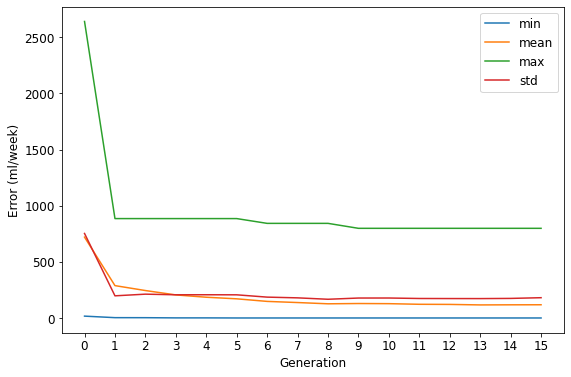

In [47]:
#Error function progression against generation number
ax = output.iloc[:,2:6].plot(xticks=output['gen'],figsize=(9,6))
ax.set_xlabel('Generation',fontsize=12)
ax.set_ylabel('Error (ml/week)',fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)

# Uncertainty analysis

## Constructing sample ranges

In [1755]:
# csv of outputs from the optimisation exercise for the threshold model 
# that generated 11 candidate calibrated paraemter sets for further analysis
df_hof_thresh = pd.read_csv('local_filepath')

In [1759]:
# create the upper and lower bounds (+/- 2%) for sensitivity analysis sampling
df_hof_T_thresh = df_hof_thresh.T
df_hof_T_thresh.columns = ['pf1','pf2','pf3','pf4','pf5','pf6','pf7','pf8','pf9','pf10','pf11']
df_hof_T_thresh = df_hof_T_thresh.reset_index()

df_range_thresh = df_hof_T_thresh.iloc[:,1:] * 0.02
df_low_thresh = df_hof_T_thresh - df_range_thresh
df_hi_thresh = df_hof_T_thresh + df_range_thresh

df_low_thresh = df_low_thresh.drop('index',axis=1)
df_hi_thresh = df_hi_thresh.drop('index',axis=1)

df_low_thresh.columns = ['pf1l','pf10l','pf11l','pf2l','pf3l','pf4l','pf5l','pf6l','pf7l','pf8l','pf9l']
df_hi_thresh.columns = ['pf1h','pf10h','pf11h','pf2h','pf3h','pf4h','pf5h','pf6h','pf7h','pf8h','pf9h']



In [1760]:
sa_param_ranges = pd.concat([df_hof_T_thresh,df_low_thresh],axis=1)

In [1761]:
sa_param_ranges = pd.concat([sa_param_ranges,df_hi_thresh],axis=1)

In [1763]:
pd.set_option('display.max_columns', None)

In [1775]:
sa_param_ranges.iloc[:,1:] = sa_param_ranges.iloc[:,1:].astype('float')

In [1783]:
sa_param_ranges.iloc[9:10,1:] = sa_param_ranges.iloc[9:10,1:].apply(lambda x: [y if y < 1 else 1 for y in x])

In [433]:
df_hof = df_hof.drop('Unnamed: 0',axis=1)

In [49]:
df_hof_T = df_hof.T

In [51]:
df_hof_T.columns = ['pf1','pf2','pf3','pf4','pf5','pf6','pf7','pf8','pf9','pf10']

In [52]:
df_hof_T = df_hof_T.reset_index()

In [55]:
df_range = df_hof_T.iloc[:,1:] * 0.02
df_low = df_hof_T - df_range
df_hi = df_hof_T + df_range

In [64]:
df_low.iloc[-1:,1:] = df_low.iloc[-1:,1:].apply(lambda x: [y if y > 14 else 14 for y in x])

In [68]:
df_low = df_low.drop('index',axis=1)
df_hi = df_hi.drop('index',axis=1)

In [70]:
df_low.columns = ['pf1l','pf10l','pf2l','pf3l','pf4l','pf5l','pf6l','pf7l','pf8l','pf9l']
df_hi.columns = ['pf1h','pf10h','pf2h','pf3h','pf4h','pf5h','pf6h','pf7h','pf8h','pf9h']

In [71]:
sa_param_ranges_prob = pd.concat([df_hof_T,df_low],axis=1)

In [72]:
sa_param_ranges_prob = pd.concat([sa_param_ranges_prob,df_hi],axis=1)

In [1786]:
# # switching round the negatives to make 'high' and 'low' bounds the correct way round
# sa_param_ranges.at[6, 'pf3h'] = -0.495708
# sa_param_ranges.at[6, 'pf3l'] = -0.515941
# sa_param_ranges.at[6, 'pf4h'] = -0.437238
# sa_param_ranges.at[6, 'pf4l'] = -0.455085
# sa_param_ranges.at[6, 'pf5h'] = -0.538837
# sa_param_ranges.at[6, 'pf5l'] = -0.560831
# sa_param_ranges.at[6, 'pf7h'] = -0.424581
# sa_param_ranges.at[6, 'pf7l'] = -0.441911
# sa_param_ranges.at[6, 'pf11h'] = -0.516679
# sa_param_ranges.at[6, 'pf11l'] = -0.537768

# #df_low 0.830761	-0.167260	-0.880514	-0.597196	0.053219	-0.782071	0.515370	0.226618	-0.549996	-0.167260
# #df_hi 0.864669	-0.174087	-0.916453	-0.621571	0.055391	-0.813993	0.536406	0.235868	-0.572445	-0.17408

# # sa_param_ranges_prob.at[6, 'pf2h'] = -0.880514
# # sa_param_ranges_prob.at[6, 'pf2l'] = -0.916453
# # sa_param_ranges_prob.at[6, 'pf3h'] = -0.597196
# # sa_param_ranges_prob.at[6, 'pf3l'] = -0.621571
# # sa_param_ranges_prob.at[6, 'pf5h'] = -0.782071
# # sa_param_ranges_prob.at[6, 'pf5l'] = -0.813993
# # sa_param_ranges_prob.at[6, 'pf8h'] = -0.549996
# # sa_param_ranges_prob.at[6, 'pf8l'] = -0.572445
# # sa_param_ranges_prob.at[6, 'pf9h'] = -0.167260
# # sa_param_ranges_prob.at[6, 'pf9l'] = -0.17408
# # sa_param_ranges_prob.at[6, 'pf10h'] = -0.167260
# # sa_param_ranges_prob.at[6, 'pf10l'] = -0.174087

In [589]:
sa_param_ranges['lower_full'] = pd.DataFrame(parameterRanges)[0]
sa_param_ranges['upper_full'] = pd.DataFrame(parameterRanges)[2]

In [2076]:
list_bounds_full = sa_param_ranges[['pf11l','pf11h']].values.tolist()

## Constructing the problem and running the sampled parameters

In [2078]:
#structure the problem with ABM parameters
ws = nl4py.newNetLogoHeadlessWorkspace()
ws.openModel('/abm_milk_choice_upload.nlogo')

problem = { 
  'num_vars': 12,
  'names': ws.getParamNames(),
  'bounds': list_bounds_full
}

In [2079]:
problem

{'num_vars': 12,
 'names': ['memory-lifetime',
  'alt-intrinsic-mean-initial',
  'habit-threshold',
  'p-interact',
  'social-susceptibility',
  'incumbent-initial-habit',
  'social-conformity',
  'alt-extrinsic-mean-initial',
  'social-blindness',
  'justification',
  'cognitive-dissonance-threshold',
  'network-parameter'],
 'bounds': [[8.174692851407766, 8.508353784118288],
  [2.21510549613595, 2.3055179653659885],
  [5.076991922197026, 5.284216082286701],
  [0.5128301775115768, 0.5337620214916411],
  [0.9185641725835744, 0.9560565877910673],
  [7.21976361723345, 7.514447846508284],
  [-0.537768, -0.516679],
  [0.6968139782914178, 0.7252553651604552],
  [0.9016932235354977, 0.938497028577763],
  [0.971234937898358, 1.0],
  [0.12304409397444893, 0.12806630189177337],
  [9.217514428688608, 9.593739507410591]]}

In [1740]:
#import package for sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

In [2081]:
# generate samples
param_values_sobol = saltelli.sample(problem, 14)

In [2083]:
# run the model with sampled parameter values
full_runs = np.array(FullRunForParameters(param_values_sobol))

364
1
2
3
4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


In [88]:
full_runs[0]

array([[2654.81      , 2608.22961224, 2506.33686949, ...,  698.93759081,
         641.01994719,  658.64773972],
       [2654.81      , 2566.48097585, 2445.72268655, ...,  660.09638049,
         611.33796787,  631.65988258],
       [2654.81      , 2632.33413255, 2576.11221446, ...,  538.13226009,
         535.33128409,  516.16584643],
       ...,
       [2654.81      , 2614.46166345, 2523.4374312 , ...,  479.38176379,
         442.68741523,  438.40243111],
       [2654.81      , 2622.62662431, 2543.93570352, ...,  510.23052389,
         471.78940122,  462.66448695],
       [2654.81      , 2602.95989028, 2543.23070137, ...,  449.49336222,
         417.65104873,  410.51153348]])

In [2084]:
# format ans save model outputs
df_runs_whole = pd.DataFrame(full_runs[0]).T
df_runs_skimmed = pd.DataFrame(full_runs[1]).T

In [2087]:
df_runs_whole.columns = ['run_pf11'] * 364

In [2088]:
df_runs_skimmed.columns = ['run_skimmed_pf11'] * 364

In [1991]:
#df_runs_milk = pd.concat([df_runs_whole,df_runs_skimmed],axis=1)

In [2089]:
df_runs_milk = pd.concat([df_runs_milk,df_runs_whole],axis=1)

In [2090]:
df_runs_milk = pd.concat([df_runs_milk,df_runs_skimmed],axis=1)

In [2091]:
df_runs_milk_obs = pd.concat([df_runs_milk,milkdata.iloc[:32,1:3]],axis=1)

In [2093]:
df_runs_milk_obs.to_csv('local_filepath')

In [49]:
df_runs_milk_obs = pd.read_csv('local_filepath')

# Sensitivity Analysis

In [94]:
# function to read a new paraemter set into the ABM to run

def simulate_sense(workspace_, parameters):
    workspace_.command("stop")
    for i, name in enumerate(problem['names']):
        workspace_.command('set {0} {1}'.format(name, parameters[i]))
    workspace_.command('setup')
    workspace_.scheduleReportersAndRun(["ticks",'mean-incum','mean-alt'], 0,1,32,"go")        

In [373]:
# function that takes the sampled paraemter sets and runs each set through the ABM, 
# recording the output (skimmed/semi-skimmed weekly milk consumption) at specific time steps

def runForParameters(experiment):
    runsDone = 0
    runsStarted = 0
    runsNeeded = experiment.shape[0]
    av_consumption_metrics = []
    import multiprocessing
    parallel_workspace_count = multiprocessing.cpu_count()
    #Delete any existing headlessworkspaces
    nl4py.deleteAllHeadlessWorkspaces()
    for i in range(0,parallel_workspace_count):
        workspace = nl4py.newNetLogoHeadlessWorkspace()
        workspace.openModel('/Applications/NetLogo 6.0.4/abm_milk_choice_upload.nlogo')
        simulate_sense(workspace,experiment[runsStarted])
        runsStarted = runsStarted + 1
        print(runsStarted)
    while (runsDone < runsNeeded):
        for workspace in nl4py.getAllHeadlessWorkspaces():
            newResults = workspace.getScheduledReporterResults()
            if len(newResults) > 0:
                ###Process simulation results###
                df = pd.DataFrame(newResults)
                #av_wholemilk = pd.to_numeric(df.iloc[:,1])
                av_skimmed = pd.to_numeric(df.iloc[26:27,2]).values
                
                ###Done processing simulation results###
                av_consumption_metrics.append(av_skimmed)
                runsDone = runsDone + 1
                print(runsDone)
                if runsStarted < runsNeeded:
                    simulate_sense(workspace,experiment[runsStarted])
                    runsStarted = runsStarted + 1
    for workspace in nl4py.getAllHeadlessWorkspaces():
        workspace.command("stop")
    nl4py.deleteAllHeadlessWorkspaces()
    
    return av_consumption_metrics

In [91]:
# same purpose as previous function but records all the model output rather than specific chosen time step

def FullRunForParameters(experiment):
    runsDone = 0
    runsStarted = 0
    runsNeeded = experiment.shape[0]
    print(runsNeeded)
    av_consumption_metrics_whole = []
    av_consumption_metrics_skimmed = []

    import multiprocessing
    parallel_workspace_count = multiprocessing.cpu_count()
    #Delete any existing headlessworkspaces
    nl4py.deleteAllHeadlessWorkspaces()
    for i in range(0,parallel_workspace_count):
        workspace = nl4py.newNetLogoHeadlessWorkspace()
        workspace.openModel('/Applications/NetLogo 6.0.4/abm_milk_choice_upload.nlogo')
        simulate_sense(workspace,experiment[runsStarted])
        runsStarted = runsStarted + 1
        print(runsStarted)

    while (runsDone < runsNeeded):
        for workspace in nl4py.getAllHeadlessWorkspaces():
            newResults = workspace.getScheduledReporterResults()
            if len(newResults) > 0:
                ###Process simulation results###
                df = pd.DataFrame(newResults)
                df.columns = ['ticks','whole','skimmed']
                av_wholemilk = pd.to_numeric(df.iloc[:,1]).values
                av_skimmed = pd.to_numeric(df.iloc[:,2]).values
                ###Done processing simulation results###
                av_consumption_metrics_whole.append(av_wholemilk)
                av_consumption_metrics_skimmed.append(av_skimmed)
                runsDone = runsDone + 1
                print(runsDone)
                if runsStarted < runsNeeded:
                    simulate_sense(workspace,experiment[runsStarted])
                    runsStarted = runsStarted + 1
    for workspace in nl4py.getAllHeadlessWorkspaces():
        workspace.command("stop")
    nl4py.deleteAllHeadlessWorkspaces()
    
    return av_consumption_metrics_whole, av_consumption_metrics_skimmed

In [374]:
# run the funtion and model with sampled parameter values. Repeat this for each of the seven time steps recorded
# the model output at discrete time periods ()
Y = np.array(runForParameters(param_values_sobol))

1
2
3
4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [368]:
len(Y)

1120

In [375]:
Y_saved = pd.DataFrame(Y)

In [376]:
Y_saved.to_csv('localfile.csv')

In [529]:
Y_new = pd.read_csv('localfile.csv')

In [346]:
Y_saved.columns = ['values']

In [347]:
Y_saved_values = Y_saved['values'].values

In [531]:
Y_new = Y_new.drop('Unnamed: 0',axis=1)

In [532]:
Y_new.columns = ['values']

In [533]:
Y_new_values = Y_new['values'].values

In [550]:
# model outputs from the sampled parameter set runs are put through sobol analysis function to 
#quantify the sensitivity at each of the 7 time steps measured

import multiprocessing
Si = sobol.analyze(problem, Y_new_values, print_to_console=True, parallel=True, n_processors=multiprocessing.cpu_count())

Parameter S1 S1_conf ST ST_conf
memory-lifetime -0.151703 0.599856 1.468398 2.608855
alt-intrinsic-mean-initial -0.021521 0.223648 0.949404 0.332164
habit-threshold -0.114041 0.528871 1.642782 4.953756
p-interact -0.085625 0.216724 1.121217 0.309454
social-susceptibility -0.189971 1.226955 1.576002 7.627650
incumbent-initial-habit 0.268490 0.833069 1.211474 1.685551
social-conformity -0.153060 0.438041 1.911456 6.536133
alt-extrinsic-mean-initial -0.025914 0.228566 0.983553 0.279521
social-blindness -0.004536 0.395600 2.132933 6.423676
justification -0.103001 0.202559 0.921246 0.602515
cognitive-dissonance-threshold -0.021667 0.253768 1.149477 1.768782
network-parameter -0.135810 0.430462 1.031676 0.750756
disposition-probability-gradient -0.074271 0.187753 0.738329 0.359478

Parameter_1 Parameter_2 S2 S2_conf
memory-lifetime alt-intrinsic-mean-initial 0.140011 0.775943
memory-lifetime habit-threshold 0.106491 0.655064
memory-lifetime p-interact 0.148953 0.536630
memory-lifetime social

# Results and visualisation

## Parameter optimisation results

In [1536]:
calib_prob = pd.read_csv('local_filepath')

In [1537]:
calib_prob = calib_prob.drop("Unnamed: 0",axis=1)

In [1743]:
# palette=['steelblue','salmon']
# fig, ax = plt.subplots(figsize=(12,9))
# #sns.violinplot(x='parameter',y='value',data=calib_prob,hue='approach',palette=palette, split=False ,scale='width')
# #sns.boxplot(x='parameter',y='value',data=calib_prob,hue='approach',palette=palette)
# #sns.scatterplot(x='parameter',y='value',data=calib_prob,hue='approach',palette=palette)
# sns.pointplot(x='Parameter',y='Value',data=calib_prob,hue='Approach',palette=palette, dodge=True, join=False)
# rect1 = mpatches.Rectangle((-.4,1),.8,9,linewidth=1,facecolor='grey',alpha=0.3)
# rect2 = mpatches.Rectangle((.6,1),.8,2,linewidth=1,facecolor='grey',alpha=0.3)
# rect3 = mpatches.Rectangle((1.6,0),.8,3,linewidth=1,facecolor='grey',alpha=0.3)
# rect4 = mpatches.Rectangle((2.6,0),.8,10,linewidth=1,facecolor='grey',alpha=0.3)
# rect5 = mpatches.Rectangle((3.6,0),.8,10,linewidth=1,facecolor='grey',alpha=0.3)
# rect6 = mpatches.Rectangle((4.6,0),.8,1,linewidth=1,facecolor='grey',alpha=0.3)
# rect7 = mpatches.Rectangle((5.6,0),.8,1,linewidth=1,facecolor='grey',alpha=0.3)
# rect8 = mpatches.Rectangle((6.6,-1),.8,2,linewidth=1,facecolor='grey',alpha=0.3)
# rect9 = mpatches.Rectangle((7.6,2),.8,8,linewidth=1,facecolor='grey',alpha=0.3)
# rect10 = mpatches.Rectangle((8.6,14),.8,2,linewidth=1,facecolor='grey',alpha=0.3)
# rect11 = mpatches.Rectangle((9.6,0),.8,1,linewidth=1,facecolor='grey',alpha=0.3)
# rect12 = mpatches.Rectangle((10.6,0),.8,1,linewidth=1,facecolor='grey',alpha=0.3)
# rect13 = mpatches.Rectangle((11.6,0),.8,1,linewidth=1,facecolor='grey',alpha=0.3)

# # Add the patch to the Axes
# ax.add_patch(rect1)
# ax.add_patch(rect2)
# ax.add_patch(rect3)
# ax.add_patch(rect4)
# ax.add_patch(rect5)
# ax.add_patch(rect6)
# ax.add_patch(rect7)
# ax.add_patch(rect8)
# ax.add_patch(rect9)
# ax.add_patch(rect10)
# ax.add_patch(rect11)
# ax.add_patch(rect12)
# ax.add_patch(rect13)

# ax.set_ylabel('Value',fontsize=14)
# ax.set_xlabel('Parameter',fontsize=14)
# ax.set_xticklabels(['Memory\nlength','                  Perception of\n                alternative\n                      Health    Environmental','','Habit\nthreshold','Initial\nhabit of\n incumbent','Probability of\ninteracting','Social\nsusceptibility','Social\nconformity','No. of\nneighbours','Gradient\nprobability\ndisposition','Social\nblindness','Post-choice\njustification','Cognitive\ndissonance\nthreshold'],fontsize=9.5)

# labels_approach = ['Probability approach','Threshold approach']

# leg2 = ax.legend(loc='upper right',bbox_to_anchor=(0.20,0.95))
# grey_dash = mpatches.Patch(color='grey', label='Parameter range',lw=0.1,alpha=0.3)
# plt.legend(handles=[grey_dash],loc='upper right',fontsize=10,bbox_to_anchor=(0.176,0.89))

# ax.add_artist(leg2)
# ax.annotate('        Choice perception       |           Habit          |               Social                         influence            |             Evaluation            ', xy=(0.0752, 0.125), xycoords='figure fraction',fontsize=12, bbox=dict(facecolor='none', edgecolor='black'))
# #ax.annotate('    Habit      ', xy=(0.28, 0.125), xycoords='figure fraction',fontsize=12, bbox=dict(facecolor='none', edgecolor='black'))
# #ax.annotate('                 Social                   influence            ', xy=(0.415, 0.125), xycoords='figure fraction',fontsize=12, bbox=dict(facecolor='none', edgecolor='black'))
# #ax.annotate('          Evaluation        ', xy=(0.76, 0.125), xycoords='figure fraction',fontsize=12, bbox=dict(facecolor='none', edgecolor='black'))

# plt.tight_layout()



## Testing values of parameter k, the gradient of the probability disposition logistic function

In [78]:
df_runs_milk_obs = pd.read_csv('local_filepath')

In [80]:
df_runs_milk_obs = df_runs_milk_obs.drop('Unnamed: 0',axis=1)

In [73]:
df_runs_milk_obs.columns = df_runs_milk_obs.iloc[0]

In [74]:
df_runs_milk_obs = df_runs_milk_obs.drop(0,axis=0)

In [75]:
df_runs_milk_obs = df_runs_milk_obs.apply(pd.to_numeric)

In [76]:
df_runs_milk_obs['skimmed_mean'] = df_runs_milk_obs.loc[:, (df_runs_milk_obs == 5.290000).any()].iloc[:,:-1].mean(axis=1)
df_runs_milk_obs['whole_mean'] = df_runs_milk_obs.loc[:, (df_runs_milk_obs == 2654.810000).any()].iloc[:,:-1].mean(axis=1)

In [1325]:
df_prob_robust = pd.read_csv('local_filepath')
df_prob_robust.columns = df_prob_robust.iloc[0]
df_prob_robust = df_prob_robust.drop(df_prob_robust.index[0])
df_prob_robust.rename(columns={df_prob_robust.columns[0]:'Unnamed: 0'}, inplace=True)
df_prob_robust = df_prob_robust.drop('Unnamed: 0',axis=1)
df_prob_robust = df_prob_robust.astype('float')

In [1326]:
mask = df_prob_robust.iloc[0] == 2654.81
df_prob_robust_whole  = df_prob_robust.loc[:, mask]
df_prob_robust_whole = df_prob_robust_whole.iloc[:,:-1]

In [1327]:
mask = df_prob_robust.iloc[0] == 5.29
df_prob_robust_skim  = df_prob_robust.loc[:, mask]
df_prob_robust_skim = df_prob_robust_skim.iloc[:,:-1]

In [1328]:
df_prob_robust_obs = df_prob_robust.iloc[:,-2:]

In [1390]:

palette1 = 'viridis'
palette2 = 'viridis'
palette3 = ['black','black']
labels1 = ['k=11','k=12','k=13','k=14','k=15','k=16','k=17','k=18']
labels2 = ['Observed wholemilk','Observed skimmed']
fig, ax = plt.subplots(figsize=(10,7))
#sns.lineplot(data=pd.concat((data_to_join,df_runs_milk_obs.iloc[:,260*20:260*20+2]),axis=1), ci='sd',dashes=True, palette=palette,legend='brief',ax=ax)
#plt.legend(loc='upper right',fontsize=12)
line1 = sns.lineplot(data=df_prob_robust_whole, ci=None,dashes=False,palette=palette1,legend='brief',label=labels1,ax=ax)
line2 = sns.lineplot(data=df_prob_robust_skim, ci=None,dashes=False,palette=palette2,legend=None,ax=ax)
line3 = sns.lineplot(data=df_prob_robust_obs, ci=None,dashes=False,palette=palette3,legend=None,ax=ax)

leg1 = ax.legend(loc='upper right',labels=labels1,bbox_to_anchor=(1,0.93))

black_dash = mpatches.Patch(color='black', label='Observed milk data',lw=0.1)
plt.legend(handles=[black_dash],loc='lower right',fontsize=12)

ax.add_artist(leg1)

ax.annotate('Gradient of probability\n                  disposition', xy=(0.705, 0.825), xycoords='figure fraction',fontsize=12)

plt.ylabel('Milk consumption per person (ml/week)',fontsize=(14))
plt.xlabel('Year',fontsize=(14))
ax.set_xticklabels(np.arange(1975, 2005+1,5),fontsize=(14))
ax.set_xticks(np.arange(1, 32+1,5))
plt.yticks(fontsize=(14))
ax.margins(x=0)


## Comparing the performance of each model approach

In [5]:
df_runs_prob = pd.read_csv('localfile.csv')
df_runs_threshold = pd.read_csv('localfile.csv')

In [7]:
df_runs_threshold.columns = df_runs_threshold.iloc[0]
df_runs_prob.columns = df_runs_prob.iloc[0]

In [8]:
df_runs_threshold = df_runs_threshold.drop(df_runs_threshold.index[0])
df_runs_prob = df_runs_prob.drop(df_runs_prob.index[0])

In [9]:
df_runs_threshold.rename(columns={df_runs_threshold.columns[0]:'Unnamed: 0'}, inplace=True)
df_runs_prob.rename(columns={df_runs_prob.columns[0]:'Unnamed: 0'}, inplace=True)

In [10]:
df_runs_threshold = df_runs_threshold.drop('Unnamed: 0',axis=1)
df_runs_prob = df_runs_prob.drop('Unnamed: 0',axis=1)

In [11]:
df_runs_threshold = df_runs_threshold.astype('float')
df_runs_prob = df_runs_prob.astype('float')

In [12]:
bp = pd.concat([(pd.DataFrame((df_runs_threshold.iloc[:,364*6:364*7].values - df_runs_prob.iloc[:,364*20:364*20+1].values)**2).mean()**0.5),(pd.DataFrame((df_runs_threshold.iloc[:,364*7:364*8].values - df_runs_prob.iloc[:,364*20+1:364*20+2].values)**2).mean()**0.5)],axis=1)
bp = pd.concat([bp,(pd.DataFrame((df_runs_prob.iloc[:,364*16:364*17].values - df_runs_prob.iloc[:,364*20:364*20+1].values)**2).mean()**0.5)],axis=1)             
bp = pd.concat([bp, (pd.DataFrame((df_runs_prob.iloc[:,364*17:364*18].values - df_runs_prob.iloc[:,364*20+1:364*20+2].values)**2).mean()**0.5)],axis=1)
bp.columns = ['threshold_whole','threshold_skim','prob_whole','prob_skim']


In [2121]:
fig=plt.figure(figsize=(12,9))

gs=GridSpec(2,2) # 2 rows, 2 columns

ax1=fig.add_subplot(gs[0,0]) # First row, first column
ax2=fig.add_subplot(gs[0,1]) # First row, second column
ax3=fig.add_subplot(gs[1,0]) # Second row, first column
ax4=fig.add_subplot(gs[1,1]) # Second row, second column

# threshold based approach results

palette1 = ['salmon','midnightblue','salmon','midnightblue','salmon','midnightblue','salmon','midnightblue','salmon','midnightblue','salmon','midnightblue','salmon','midnightblue','salmon','midnightblue','salmon','midnightblue','salmon','midnightblue','black','black']
#palette = ['b','b','gold','gold','mediumseagreen','mediumseagreen']
data_to_join = pd.concat((df_runs_threshold.iloc[:,:364*2],df_runs_threshold.iloc[:,364*6:364*8]),axis=1)
data = pd.concat((data_to_join,df_runs_threshold.iloc[:,364*20:364*20+2]),axis=1)
#data = df_runs_milk_obs
#labels = ['Crossover best run (wholemilk)','Crossover best run (skimmed)','Final value best run (wholemilk)','Final value best run (skimmed)','Observed wholemilk','Observed skimmed']
sns.lineplot(data=df_runs_threshold, ci='sd',palette=palette1,dashes=False,legend=None,ax=ax1)
#plt.legend(loc='upper right',fontsize=12)
#ax1.legend(labels,fontsize=12)
#ax1.set_xlim(1,32)
ax1.set_ylabel('Consumption per person (ml/week)',fontsize=(14))
ax1.set_xticklabels(np.arange(1975, 2005+1,5),fontsize=(14))
ax1.set_xticks(np.arange(2, 32+1,5))
plt.yticks(fontsize=(14))
ax1.margins(x=0)
#ax1.margins(y=0)

# probability based approach results

#palette = sns.color_palette("Paired",6)
palette2 = ['orange','teal','orange','teal','orange','teal','orange','teal','orange','teal','orange','teal','orange','teal','orange','teal','orange','teal','orange','teal','black','black']
#palette = ['b','b','gold','gold','mediumseagreen','mediumseagreen']
data_to_join = pd.concat((df_runs_prob.iloc[:,:364*2],df_runs_milk_obs.iloc[:,364*6:364*8]),axis=1)
data = pd.concat((data_to_join,df_runs_prob.iloc[:,364*20:364*20+2]),axis=1)
#data = df_runs_milk_obs
#labels = ['Crossover best run (wholemilk)','Crossover best run (skimmed)','Final value best run (wholemilk)','Final value best run (skimmed)','Observed wholemilk','Observed skimmed']
sns.lineplot(data=df_runs_prob, ci='sd',dashes=False, palette=palette2,legend=None,ax=ax2)
#plt.legend(loc='upper right',fontsize=12)
#ax.legend(labels,fontsize=12)
ax2.set_ylabel('Consumption per person (ml/week)',fontsize=(14))
#ax2.set_xlim(0,31)
ax2.set_xticklabels(np.arange(1975, 2005+1,5),fontsize=(14))
ax2.set_xticks(np.arange(2, 32+1,5))
plt.yticks(fontsize=(14))
ax2.margins(x=0)

# probability based approach results

#palette = sns.color_palette("Paired",6)
#palette = ['b','b','g','g','orange','orange','gold','gold','salmon','salmon','navy','navy','slategrey','slategrey','red','red','aqua','aqua','m','m','black','black']
palette = ['black','black','salmon','midnightblue','orange','teal']
data_to_join = pd.concat((df_runs_threshold.iloc[:,260*6:260*8],df_runs_prob.iloc[:,364*16:364*18]),axis=1)
data = pd.concat((df_runs_prob.iloc[:,364*20:364*20+2],data_to_join),axis=1)
#data = df_runs_milk_obs
#labels = ['Crossover best run (wholemilk)','Crossover best run (skimmed)','Final value best run (wholemilk)','Final value best run (skimmed)','Observed wholemilk','Observed skimmed']
sns.lineplot(data=data, ci='sd',dashes=False, palette=palette,legend=None,ax=ax3)
#plt.legend(loc='upper right',fontsize=12)
#ax.legend(labels,fontsize=12)
ax3.set_ylabel('Consumption per person (ml/week)',fontsize=(14))
#ax3.set_xlim(0,31)
ax3.set_xticklabels(np.arange(1975, 2005+1,5),fontsize=(14))
ax3.set_xticks(np.arange(2, 32+1,5))
ax3.set_xlabel('Year',fontsize=14)
plt.yticks(fontsize=(14))
ax3.margins(x=0)

palette3 = ['salmon','midnightblue','orange','teal']
sns.boxplot(data=bp,palette=palette3,ax=ax4)
ax4.set_xticklabels(['                    Threshold approach','','                    Probability approach',''],fontsize=(14))
ax4.set_ylabel('Root mean squared error (ml/week)',fontsize=(14))

ax1.annotate('a)', xy=(0.08, .933), xycoords='figure fraction',fontsize=14)
ax2.annotate('b)', xy=(0.585, .933), xycoords='figure fraction',fontsize=14)
ax3.annotate('c)', xy=(0.08, .47), xycoords='figure fraction',fontsize=14)
ax4.annotate('d)', xy=(0.585, .47), xycoords='figure fraction',fontsize=14)

leg3 = ax1.legend(['threshold model - wholemilk','threshold model - skimmed'],fontsize=12)
for i in leg3.legendHandles:
    i.set_linewidth(2)
    
leg4 = ax2.legend(['probability model - wholemilk','probability model - skimmed'],fontsize=12)
for i in leg4.legendHandles:
    i.set_linewidth(2)
    
leg5 = ax3.legend(['observed milk data'],fontsize=12)
for i in leg5.legendHandles:
    i.set_linewidth(2)

plt.subplots_adjust(hspace=0.35)
plt.tight_layout()

# Sensitivity Analysis

In [551]:
sobol_first_list = [Si['S1'],Si['S1_conf'],Si['ST'],Si['ST_conf']]

In [552]:
sobol_first = pd.DataFrame(sobol_first_list).T

In [553]:
sobol_first.columns = ['S1', 'S1_conf','ST','ST_conf']

In [554]:
sobol_first['Parameter'] = ['memory-lifetime', 'alt-intrinsic-mean-initial', 'habit-threshold', 'p-interact', 'social-susceptibility', 'incumbent-initial-habit', 'social-conformity', 'alt-extrinsic-mean-initial', 'social-blindness', 'justification', 'cognitive-dissonance-threshold', 'network-parameter','disposition-probability-gradient']

In [555]:
sobol_first.to_csv('localfile.csv')

In [556]:
sobol_second_list = [Si['S2'], Si['S2_conf']]

In [558]:
sobol_second = pd.DataFrame(np.concatenate(sobol_second_list)).T

In [559]:
sobol_second.columns = ['S2_memory-lifetime', 'S2_alt-intrinsic-mean-initial', 'S2_habit-threshold', 'S2_p-interact', 'S2_social-susceptibility', 'S2_incumbent-initial-habit', 'S2_social-conformity', 'S2_alt-extrinsic-mean-initial', 'S2_social-blindness', 'S2_justification', 'S2_cognitive-dissonance-threshold', 'S2_network-parameter','S2_disposition-probability-gradient','conf_memory-lifetime', 'conf_alt-intrinsic-mean-initial', 'conf_habit-threshold', 'conf_p-interact', 'conf_social-susceptibility', 'conf_incumbent-initial-habit', 'conf_social-conformity', 'conf_alt-extrinsic-mean-initial', 'conf_social-blindness', 'conf_justification', 'conf_cognitive-dissonance-threshold', 'conf_network-parameter','conf_disposition-probability-gradient']

In [560]:
sobol_second.to_csv('localfile.csv')

In [561]:
sobol_s1_abs.sum()

1.6877565771465046

In [562]:
sobol_st_abs.sum()

10.925680427078325

In [563]:
sobol_s1_abs = np.abs(Si["S1"])
sobol_st_abs = np.abs(Si["ST"])

In [564]:
S1_and_interactions_sobol = np.append(sobol_s1_abs,(sobol_st_abs.sum()-sobol_s1_abs.sum()))

In [812]:
sobol_first = pd.read_csv('localfile.csv')

In [813]:
sobol_first['S1_abs'] = np.abs(sobol_first['S1'])

In [814]:
sobol_first['S1_int'] = sobol_first['ST'] - sobol_first['S1_abs']

In [815]:
sobol_first['S1_tot'] = sobol_first['S1_abs'] + sobol_first['S1_int']

In [780]:
#S1_split_interactions = []

In [817]:
S1_split_interactions.append(sobol_first['S1_tot'])

In [818]:
S1_split_interactions = pd.DataFrame(S1_split_interactions)

In [822]:
S1_split_interactions.to_csv('localfile.csv')

In [644]:
# mylist = S1_and_interactions_sobol
# myorder = [1, 7, 0, 12, 2,5,3,4,11,6,10,9,8]
# mylist = [mylist[i] for i in myorder]

In [645]:
#S1_and_interactions_sobol = mylist

In [646]:
#labels = mylist

In [834]:
labels = ['Initial perception of intrinsic component of alternative',
 'Initial perception of extrinsic component of alternative',
 'Memory length',
 'Interactions',
 'Habit threshold',
 'Initial habit of incumbent',
 'Probability of interacting',
 'Social susceptibility',
 'Average number of neighbours',
 'Social conformity',
 'Cognitive dissonance threshold',
 'Post-choice justification',
 'Social blindness']

labels_int = ['Initial perception of intrinsic component of alternative',
 'Initial perception of extrinsic component of alternative',
 'Memory length',
 'Habit threshold',
 'Initial habit of incumbent',
 'Probability of interacting',
 'Social susceptibility',
 'Average number of neighbours',
 'Social conformity',
 'Cognitive dissonance threshold',
 'Post-choice justification',
 'Social blindness']

labels_prob = ['memory-lifetime',
'alt-intrinsic-mean-initial',
'habit-threshold',
'p-interact',
'social-susceptibility',
'incumbent-initial-habit',
'social-conformity',
'alt-extrinsic-mean-initial',
'social-blindness',
'justification',
'cognitive-dissonance-threshold',
'network-parameter',
'disposition-probability-gradient',
              'interactions']

labels_prob_wo_int = ['memory-lifetime',
'alt-intrinsic-mean-initial',
'habit-threshold',
'p-interact',
'social-susceptibility',
'incumbent-initial-habit',
'social-conformity',
'alt-extrinsic-mean-initial',
'social-blindness',
'justification',
'cognitive-dissonance-threshold',
'network-parameter',
'disposition-probability-gradient']

In [565]:
S1_and_interactions_sobol

array([1.51703202e-01, 2.15205991e-02, 1.14040938e-01, 8.56247584e-02,
       1.89970855e-01, 2.68490094e-01, 1.53060473e-01, 2.59136858e-02,
       4.53590344e-03, 1.03000999e-01, 2.16665653e-02, 1.35809838e-01,
       7.42710458e-02, 1.54883385e+01])

In [399]:
#temp_sa = []

In [566]:
temp_sa.append(S1_and_interactions_sobol)

In [567]:
df_temp_sa = pd.DataFrame(temp_sa)

In [568]:
df_temp_sa.to_csv('localfile.csv')

In [573]:
df_temp_sa.columns = labels_prob

In [575]:
df_temp_sa = df_temp_sa.T.sort_values(df_temp_sa.index[0], ascending=False).T

In [576]:
df_temp_sa['Year'] = ['1975','1980','1985','1990','1995','2000','2005']

In [596]:
df_temp_sa_1 = pd.read_csv('localfile.csv')

In [597]:
df_temp_sa_1 = df_temp_sa_1.drop('Unnamed: 0',axis=1)

In [598]:
df_temp_sa_1.columns = labels

In [600]:
df_temp_sa_1 = df_temp_sa_1.T.sort_values(df_temp_sa_1.index[0], ascending=False).T

In [601]:
df_temp_sa_1['Year'] = ['1975','1980','1985','1990','1995','2000','2005']

In [623]:
df_temp_sa_1_pc = df_temp_sa_1.set_index('Year')
df_temp_sa_1_pc = df_temp_sa_1_pc.div(df_temp_sa_1_pc.sum(axis=1), axis=0)

In [640]:
df_temp_sa_pc = df_temp_sa.set_index('Year')
df_temp_sa_pc = df_temp_sa_pc.div(df_temp_sa_pc.sum(axis=1), axis=0)

In [823]:
S1_split_interactions = pd.read_csv('localfile.csv')

In [826]:
S1_split_interactions = S1_split_interactions.drop('Unnamed: 0',axis=1)

In [838]:
#S1_split_interactions.columns = labels_prob_wo_int

In [ ]:
S1_split_interactions['Year'] = ['1975','1980','1985','1990','1995','2000','2005']

In [855]:
S1_split_interactions_combined = S1_split_interactions['memory-lifetime'] + S1_split_interactions['alt-intrinsic-mean-initial'] + S1_split_interactions['alt-extrinsic-mean-initial']

In [862]:
S1_split_interactions_combined = pd.DataFrame(S1_split_interactions_combined)

In [863]:
S1_split_interactions_combined.columns = ['Cognitive perception']

In [865]:
S1_split_interactions_combined['Habit'] = S1_split_interactions['habit-threshold'] + S1_split_interactions['incumbent-initial-habit']

In [867]:
S1_split_interactions_combined['Social influence'] = S1_split_interactions['p-interact'] + S1_split_interactions['social-susceptibility'] + S1_split_interactions['social-conformity'] + S1_split_interactions['network-parameter'] + S1_split_interactions['disposition-probability-gradient']

In [868]:
S1_split_interactions_combined['Evaluation'] = S1_split_interactions['social-blindness'] + S1_split_interactions['justification'] + S1_split_interactions['cognitive-dissonance-threshold']

In [871]:
S1_split_interactions_combined['Year'] = S1_split_interactions['Year']

In [872]:
S1_split_interactions_combined_pc = S1_split_interactions_combined.set_index('Year')
S1_split_interactions_combined_pc = S1_split_interactions_combined_pc.div(S1_split_interactions_combined_pc.sum(axis=1), axis=0)

In [829]:
S1_split_interactions_pc = S1_split_interactions.set_index('Year')
S1_split_interactions_pc = S1_split_interactions_pc.div(S1_split_interactions_pc.sum(axis=1), axis=0)

In [832]:
S1_split_interactions_threshold = pd.read_csv('localfile.csv')

In [833]:
S1_split_interactions_threshold = S1_split_interactions_threshold.drop('Unnamed: 0',axis=1)

In [840]:
S1_split_interactions_threshold.columns = labels_int

In [841]:
S1_split_interactions_threshold['Year'] = ['1975','1980','1985','1990','1995','2000','2005']

In [842]:
S1_split_interactions_threshold_pc = S1_split_interactions_threshold.set_index('Year')
S1_split_interactions_threshold_pc = S1_split_interactions_threshold_pc.div(S1_split_interactions_threshold_pc.sum(axis=1), axis=0)

In [876]:
S1_split_interactions_combined_threshold = S1_split_interactions_threshold['Memory length'] + S1_split_interactions_threshold['Initial perception of intrinsic component of alternative'] + S1_split_interactions_threshold['Initial perception of extrinsic component of alternative']

In [877]:
S1_split_interactions_combined_threshold = pd.DataFrame(S1_split_interactions_combined_threshold)

In [878]:
S1_split_interactions_combined_threshold.columns = ['Cognitive perception']

In [879]:
S1_split_interactions_combined_threshold['Habit'] = S1_split_interactions_threshold['Habit threshold'] + S1_split_interactions_threshold['Initial habit of incumbent']

In [881]:
S1_split_interactions_combined_threshold['Social influence'] = S1_split_interactions_threshold['Probability of interacting'] + S1_split_interactions_threshold['Social susceptibility'] + S1_split_interactions_threshold['Social conformity'] + S1_split_interactions_threshold['Average number of neighbours']

In [882]:
S1_split_interactions_combined_threshold['Evaluation'] = S1_split_interactions_threshold['Social blindness'] + S1_split_interactions_threshold['Post-choice justification'] + S1_split_interactions_threshold['Cognitive dissonance threshold']

In [883]:
S1_split_interactions_combined_threshold['Year'] = S1_split_interactions_threshold['Year']

In [884]:
S1_split_interactions_combined_threshold_pc = S1_split_interactions_combined_threshold.set_index('Year')
S1_split_interactions_combined_threshold_pc = S1_split_interactions_combined_threshold_pc.div(S1_split_interactions_combined_threshold_pc.sum(axis=1), axis=0)

In [895]:
S1_split_interactions_combined_threshold_pc.index

Index(['1975', '1980', '1985', '1990', '1995', '2000', '2005'], dtype='object', name='Year')

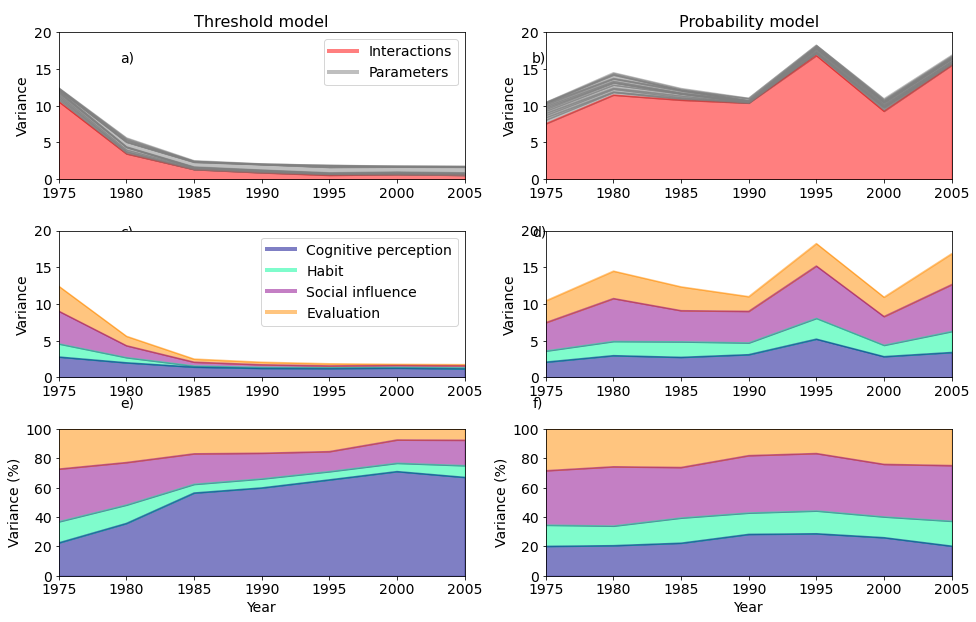

In [1739]:
colormap1 = ['red','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey']
colormap2 = ['red','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey']
colormap3 = ['darkblue','mediumspringgreen','darkmagenta','darkorange']

fig, ax = plt.subplots(3,2)
ax1 = S1_split_interactions_combined.plot(kind='area', stacked=True, alpha=0.5, color=colormap3,
        legend=False,figsize=(16,10),ax=ax[1,1])
ax[1,1].set_xticklabels(S1_split_interactions['Year'],fontsize=14)
ax[1,1].set_xlim(0,6)
ax[1,1].set_ylim(0,20)
#ax[1,1].set_xlabel('Year',fontsize=14)
ax[1,1].set_ylabel('Variance',fontsize=14)
#ax[1,1].set_title('Temporal global sensitivity analysis',fontsize=16)
#plt.legend(fontsize=10)

ax2 = df_temp_sa.plot(kind='area', stacked=True, alpha=0.5, color=colormap1,
        legend=False,figsize=(16,8),ax=ax[0,1])
ax[0,1].set_xticklabels(df_temp_sa['Year'],fontsize=14)
ax[0,1].set_xlim(0,6)
ax[0,1].set_ylim(0,20)
#ax[0,1].set_xlabel('Year',fontsize=14)
ax[0,1].set_ylabel('Variance',fontsize=14)
ax[0,1].set_title('Probability model',fontsize=16)

#plt.legend(fontsize=10)

ax3 = S1_split_interactions_combined_pc.plot(kind='area', stacked=True, alpha=0.5, color=colormap3,
        legend=False,figsize=(16,10),ax=ax[2,1])
#ax[2,1].set_xticklabels(S1_split_interactions_combined_pc.index,fontsize=12)
ax[2,1].tick_params(axis='both', which='major', labelsize=14)
ax[2,1].set_xlim(0,6)
ax[2,1].set_ylim(0,1)
#plt.rc('ytick',labelsize=14)
ax[2,1].set_xlabel('Year',fontsize=14)
ax[2,1].set_ylabel('Variance (%)',fontsize=14)
ax[2,1].set_yticklabels(np.arange(0,101,20),fontsize=14)
#ax[2,1].set_title('Temporal global sensitivity analysis - probability',fontsize=16)
#plt.legend(fontsize=10)

ax4 = S1_split_interactions_combined_threshold.plot(kind='area', stacked=True, alpha=0.5, color=colormap3,
        legend=False,figsize=(16,10),ax=ax[1,0])
ax[1,0].set_xticklabels(S1_split_interactions_combined_threshold['Year'],fontsize=14)
ax[1,0].set_xlim(0,6)
ax[1,0].set_ylim(0,20)
#plt.rc('ytick',labelsize=14)
#ax[1,0].set_xlabel('Year',fontsize=14)
ax[1,0].set_ylabel('Variance',fontsize=14)
leg1 = ax[1,0].legend(['Cognitive perception','Habit','Social influence','Evaluation'],fontsize=14)
for i in leg1.legendHandles:
    i.set_linewidth(4)
#ax[1,0].set_title('Temporal global sensitivity analysis',fontsize=16)

ax5 = df_temp_sa_1.plot(kind='area', stacked=True, alpha=0.5, color=colormap2,
        legend=False,figsize=(16,10),ax=ax[0,0])
ax[0,0].set_xticklabels(df_temp_sa_1['Year'],fontsize=14)
ax[0,0].set_xlim(0,6)
ax[0,0].set_ylim(0,20)
#plt.rc('ytick',labelsize=14)
#ax[0,0].set_xlabel('Year',fontsize=14)
ax[0,0].set_ylabel('Variance',fontsize=14)
ax[0,0].set_title('Threshold model',fontsize=16)
leg2 = ax[0,0].legend(['Interactions','Parameters'],fontsize=14)
for i in leg2.legendHandles:
    i.set_linewidth(4)


ax6 = S1_split_interactions_combined_threshold_pc.plot(kind='area', stacked=True, alpha=0.5, color=colormap3,
        legend=False,figsize=(16,10),ax=ax[2,0])
#ax[2,0].set_xticklabels(S1_split_interactions_combined_threshold_pc.index,fontsize=12)
ax[2,0].tick_params(axis='both', which='major', labelsize=14)
ax[2,0].set_xlim(0,6)
ax[2,0].set_ylim(0,1)
#plt.rc('ytick',labelsize=14)
ax[2,0].set_xlabel('Year',fontsize=14)
ax[2,0].set_ylabel('Variance (%)',fontsize=14)
ax[2,0].set_yticklabels(np.arange(0,101,20),fontsize=14)
#ax[2,0].set_title('Temporal global sensitivity analysis',fontsize=16)
#plt.legend(fontsize=10)

ax[0,0].annotate('a)', xy=(0.123, .9), xycoords='figure fraction',fontsize=14)
ax[1,0].annotate('b)', xy=(0.545, .9), xycoords='figure fraction',fontsize=14)
ax[0,1].annotate('c)', xy=(0.123, .62), xycoords='figure fraction',fontsize=14)
ax[1,1].annotate('d)', xy=(0.545, .62), xycoords='figure fraction',fontsize=14)
ax[2,1].annotate('e)', xy=(0.123, .345), xycoords='figure fraction',fontsize=14)
ax[2,0].annotate('f)', xy=(0.545, .345), xycoords='figure fraction',fontsize=14)

plt.subplots_adjust(wspace=0.2,hspace=0.35)

#plt.tight_layout()